In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

sns.set()

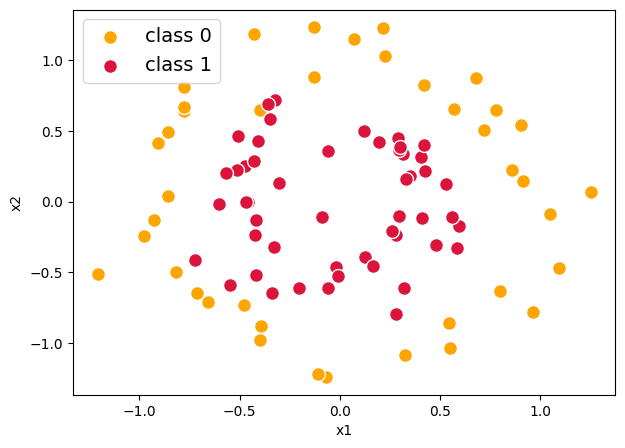

In [7]:
import sklearn.datasets as datasets
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

data = datasets.make_circles(n_samples=100, factor=0.5, noise=0.15, random_state=0)
x, y = data[0], data[1]

# make it imbalance
idx = np.sort(np.append(np.where(y != 0)[0], np.where(y == 0)[0][:-10]))
x, y = x[idx], y[idx]

plt.figure(figsize=(7, 5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='orange', edgecolors='w', s=100, label='class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='crimson', edgecolors='w', s=100, label='class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(fontsize=14)
plt.show()

In [10]:
import plotly.graph_objects as go
import plotly.io as pio

# Force rendering in browser
pio.renderers.default = "browser"

c_scale = [[0, "rgb(247, 168, 84)"], [1, "rgb(209, 0, 0)"]]

def create_scatter(x, y, plot_type):
    return go.Scatter3d(
        x=x[:, 0], y=x[:, 1], z=y,
        mode="markers",
        marker=dict(
            size=6,
            color=y,
            colorscale=c_scale if plot_type == "pred" else "Blugrn",
            line=dict(width=4, color="White"),
        ),
    )

def format_plot(fig):
    return fig.update_layout(
        scene=dict(
            xaxis_title="x1",
            yaxis_title="x2",
            zaxis_title="y"
        ),
        height=400,
        width=600,
        margin=dict(l=10, r=10, t=40, b=20),
    )

# Example data (since you didn’t share x and y)
import numpy as np
x = np.random.rand(100, 2) * 10
y = np.random.rand(100) * 20

fig = go.Figure()
fig.add_trace(create_scatter(x, y, "pred"))
fig = format_plot(fig)
fig.show()


In [11]:
x1_min, x1_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
x2_min, x2_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5

h = 0.02  # step size in the mesh
x1_mesh, x2_mesh = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))

In [12]:
def create_surface(x1, x2, y, plot_type):
    
    return go.Surface(x=x1, y=x2, z=y, 
                      showscale=False, 
                      opacity=0.5, 
                      colorscale="Peach" if plot_type == "pred" else "Tealgrn",
                      )

In [13]:
p = y.mean()

fig = go.Figure()
fig.add_trace(create_scatter(x, y, "pred"))
fig.add_trace(create_surface(x1_mesh, x2_mesh, np.full(x1_mesh.shape, p), "pred"))
fig = format_plot(fig)
fig.show()

In [14]:
def create_residual_lines(x, y, pred):
    
    #create the coordinate list for the lines
    x_list, y_list, z_list = [], [], []
    for i in range(len(x)):
        x_list.extend([x[i, 0], x[i, 0], None])
        y_list.extend([x[i, 1], x[i, 1], None])
        z_list.extend([y[i], pred[i], None])

    return go.Scatter3d(x=x_list, 
                         y=y_list, 
                         z=z_list, 
                         mode='lines',
                         line=dict(
                             color='brown',
                             width=5
                         ))

In [15]:
fig = go.Figure()
fig.add_trace(create_scatter(x, y, "pred"))
fig.add_trace(create_surface(x1_mesh, x2_mesh, np.full(x1_mesh.shape, p), "pred"))
fig.add_trace(create_residual_lines(x, y, np.full(y.shape, p)))
fig = format_plot(fig)
fig.update_layout(showlegend=False)
fig.show()

In [16]:
def train_and_update(x, y, Fm, x1_mesh, x2_mesh, Fm_mesh, learing_rate=0.1, print_tree=True):
    
    p = np.exp(Fm) / (1 + np.exp(Fm))
    r = y - p
    tree = DecisionTreeRegressor(max_depth=1, random_state=0)
    tree.fit(x, r)
    ids = tree.apply(x)

    if print_tree:
      print_tree_structure(tree)

    x_mesh = np.c_[x1_mesh.ravel(), x2_mesh.ravel()]
    r_pred_mesh = tree.predict(x_mesh).reshape(x1_mesh.shape)

    for j in np.unique(ids):
        fltr = ids == j
        num = r[fltr].sum()
        den = (p[fltr]*(1-p[fltr])).sum()
        gamma = num / den
        Fm[fltr] += learing_rate * gamma

        # update prediction value in the tree
        tree.tree_.value[j, 0, 0] = gamma

    gamma_update_mesh = tree.predict(x_mesh).reshape(x1_mesh.shape)
    Fm_mesh += learing_rate * gamma_update_mesh

    p_mesh = np.exp(Fm_mesh) / (1 + np.exp(Fm_mesh))
    
    return tree, r, Fm, r_pred_mesh, Fm_mesh

In [19]:
# this function print out tree structures. adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def print_tree_structure(clf):
    
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print('-'*80)
    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node.".format(
                    space=node_depth[i] * "\t", node=i
                )
            )
            print(node_depth[i] * '\t', f"prediction: {clf.tree_.value[i, 0, 0]:.1f}")
        else:
            print(
                "{space}node={node} is a split node: "
                "go to node {left} if X[:, {feature}] <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=feature[i],
                    threshold=threshold[i],
                    right=children_right[i],
                )
            )
    print('-'*80)

In [21]:
eps = 1e-10
p = np.clip(p, eps, 1 - eps)
F0 = np.log(p / (1 - p))

F0 = np.full(len(y), F0)
F0_mesh = np.full(x1_mesh.shape, F0[0])
learing_rate = 0.9
tree, r, Fm, r_pred_mesh, Fm_mesh = train_and_update(x, y, F0, x1_mesh, x2_mesh, F0_mesh, learing_rate=learing_rate)

fig = go.Figure()
fig.add_trace(create_scatter(x, r, "res"))
fig.add_trace(create_surface(x1_mesh, x2_mesh, r_pred_mesh, "res"))
fig = format_plot(fig)
fig.update_layout(showlegend=False)
fig.show()

--------------------------------------------------------------------------------
The binary tree structure has 3 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 0] <= 2.2531557083129883 else to node 2.
	node=1 is a leaf node.
	 prediction: 6.5
	node=2 is a leaf node.
	 prediction: 9.6
--------------------------------------------------------------------------------


C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\3544222192.py:28: RuntimeWarning:

overflow encountered in exp

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\3544222192.py:28: RuntimeWarning:

invalid value encountered in divide



In [22]:
print_tree_structure(tree)

--------------------------------------------------------------------------------
The binary tree structure has 3 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 0] <= 2.2531557083129883 else to node 2.
	node=1 is a leaf node.
	 prediction: 65435543068.0
	node=2 is a leaf node.
	 prediction: 96451658431.4
--------------------------------------------------------------------------------


In [23]:
def create_prev_surface(x1, x2, y, plot_type):
    
    return go.Surface(x=x1, y=x2, z=y, 
                      showscale=False, 
                      opacity=0.5, 
                      colorscale="Purples",
                      surfacecolor=np.ones(x1.shape),
                      )

In [24]:
p_mesh = np.exp(Fm_mesh) / (1 + np.exp(Fm_mesh))

fig = go.Figure()
fig.add_trace(create_scatter(x, y, "pred"))
fig.add_trace(create_prev_surface(x1_mesh, x2_mesh, np.full(x1_mesh.shape, p), "pred"))
fig.add_trace(create_surface(x1_mesh, x2_mesh, p_mesh, "pred"))
fig = format_plot(fig)
fig.update_layout(showlegend=False)
fig.show()

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\551835456.py:1: RuntimeWarning:

overflow encountered in exp

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\551835456.py:1: RuntimeWarning:

invalid value encountered in divide



In [27]:
def sigmoid(z):
    # numerically stable sigmoid
    return np.where(
        z >= 0,
        1 / (1 + np.exp(-z)),
        np.exp(z) / (1 + np.exp(z))
    )


In [28]:
p = sigmoid(Fm)

fig = go.Figure()
fig.add_trace(create_scatter(x, y, "pred"))
fig.add_trace(create_surface(x1_mesh, x2_mesh, p_mesh, "pred"))
fig.add_trace(create_residual_lines(x, y, p))
fig = format_plot(fig)
fig.update_layout(title="Updated Residuals", showlegend=False)
fig.show()

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\809916717.py:6: RuntimeWarning:

overflow encountered in exp

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\809916717.py:6: RuntimeWarning:

invalid value encountered in divide



In [26]:
p_mesh_prev = p_mesh
tree, r, Fm, r_pred_mesh, Fm_mesh = train_and_update(x, y, Fm, x1_mesh, x2_mesh, Fm_mesh, learing_rate=learing_rate)

fig = go.Figure()
fig.add_trace(create_scatter(x, r, "res"))
fig.add_trace(create_surface(x1_mesh, x2_mesh, r_pred_mesh, "res"))
fig = format_plot(fig)
fig.update_layout(showlegend=False)
fig.show()

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\3544222192.py:3: RuntimeWarning:

overflow encountered in exp

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\3544222192.py:3: RuntimeWarning:

invalid value encountered in divide



ValueError: Input y contains NaN.

In [29]:
p_mesh = np.exp(Fm_mesh) / (1 + np.exp(Fm_mesh))

fig = go.Figure()
fig.add_trace(create_scatter(x, y, "pred"))

fig.add_trace(create_prev_surface(x1_mesh, x2_mesh, p_mesh_prev, "pred"))
fig.add_trace(create_surface(x1_mesh, x2_mesh, p_mesh, "pred"))
p = np.exp(Fm) / (1 + np.exp(Fm))
# fig.add_trace(create_residual_lines(x, y, pred))
fig = format_plot(fig)
fig.update_layout(showlegend=False)
fig.show()

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\4098619985.py:1: RuntimeWarning:

overflow encountered in exp

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\4098619985.py:1: RuntimeWarning:

invalid value encountered in divide

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\4098619985.py:8: RuntimeWarning:

overflow encountered in exp

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\4098619985.py:8: RuntimeWarning:

invalid value encountered in divide



In [30]:
def create_subplots(iter_num):
    
    return make_subplots(
        rows=1, cols=2,
        specs=[[{"is_3d": True}, {"is_3d": True}]],
        horizontal_spacing=0,
        subplot_titles=(f"Residuals of iteration {iter_num}", f"Predictions of iteration {iter_num}"),
    )
    
def format_subplots(fig):
    fig.update_layout(
        scene=dict(
            xaxis_title="x1", 
            yaxis_title="x2", 
            zaxis_title="y"
        ),
        scene2=dict(
            xaxis_title="x1", 
            yaxis_title="x2", 
            zaxis_title="y"
        ),
        height=400,
        width=1200,
        margin=dict(l=10, r=10, t=20, b=20),
    )
    fig.update_layout(showlegend=False)
    return fig

In [31]:
p = y.mean()
F0 = np.log(p/(1-p))

learing_rate = 0.9
Fm_mesh = np.full(x1_mesh.shape, F0)
Fm = np.full(len(y), F0)
n_estimators = 4
p = y.mean()

fig = create_subplots(0)
fig.append_trace(create_scatter(x, y, "pred"), row=1, col=2)
fig.append_trace(create_surface(x1_mesh, x2_mesh, np.full(x1_mesh.shape, p), "pred"), row=1, col=2)
fig = format_subplots(fig)
fig.show()

for i in range(n_estimators):
    tree, r, Fm, r_pred_mesh, Fm_mesh = train_and_update(x, y, Fm, x1_mesh, x2_mesh, Fm_mesh, 
                                                         learing_rate=learing_rate, print_tree=False)
    p_mesh = np.exp(Fm_mesh) / (1 + np.exp(Fm_mesh))

    fig = create_subplots(i+1)
    fig.append_trace(create_scatter(x, r, "res"), row=1, col=1)
    fig.append_trace(create_surface(x1_mesh, x2_mesh, r_pred_mesh, "res"), row=1, col=1)
    fig.append_trace(create_scatter(x, y, "pred"), row=1, col=2)
    fig.append_trace(create_surface(x1_mesh, x2_mesh, p_mesh, "pred"), row=1, col=2)

    fig = format_subplots(fig)
    fig.show()

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\4038625782.py:2: RuntimeWarning:

invalid value encountered in log



ValueError: Input y contains NaN.

In [32]:
class CustomGradientBoostingClassifier:
    
    def __init__(self, learning_rate, n_estimators, max_depth=1):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        
    def fit(self, X, y):
        
        F0 = np.log(y.mean()/(1-y.mean()))  # log-odds values
        self.F0 = np.full(len(y), F0)  # converting to array with the input length
        Fm = self.F0.copy()
        
        for _ in range(self.n_estimators):
            p = np.exp(Fm) / (1 + np.exp(Fm))  # converting back to probabilities
            r = y - p  # residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=0)
            tree.fit(X, r)
            ids = tree.apply(x)  # getting the terminal node IDs

            # looping through the terminal nodes 
            for j in np.unique(ids):
              fltr = ids == j

              # getting gamma using the formula (Σresiduals/Σp(1-p))
              num = r[fltr].sum()
              den = (p[fltr]*(1-p[fltr])).sum()
              gamma = num / den

              # updating the prediction
              Fm[fltr] += self.learning_rate * gamma

              # replacing the prediction value in the tree
              tree.tree_.value[j, 0, 0] = gamma

            self.trees.append(tree)
            
    def predict_proba(self, X):
        
        Fm = self.F0
        
        for i in range(self.n_estimators):
            Fm += self.learning_rate * self.trees[i].predict(X)
            
        return np.exp(Fm) / (1 + np.exp(Fm))  # converting back to probabilities

In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss

custom_gbm = CustomGradientBoostingClassifier(
    n_estimators=20, 
    learning_rate=0.1, 
    max_depth=1
)
custom_gbm.fit(x, y)
custom_gbm_log_loss = log_loss(y, custom_gbm.predict_proba(x))
print(f"Custom GBM Log-Loss:{custom_gbm_log_loss:.15f}")

sklearn_gbm = GradientBoostingClassifier(
    n_estimators=20, 
    learning_rate=0.1, 
    max_depth=1
)
sklearn_gbm.fit(x, y)
sklearn_gbm_log_loss = log_loss(y, sklearn_gbm.predict_proba(x))
print(f"Scikit-learn GBM Log-Loss:{sklearn_gbm_log_loss:.15f}")

C:\Users\Gargi\AppData\Local\Temp\ipykernel_7368\1308631967.py:11: RuntimeWarning:

invalid value encountered in log



ValueError: Input y contains NaN.